# Air quality project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, 
                                   KBinsDiscretizer, FunctionTransformer, PolynomialFeatures, LabelEncoder)
from sklearn.impute import SimpleImputer, KNNImputer 
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (accuracy_score, recall_score, precision_score, precision_recall_curve, classification_report, confusion_matrix, 
                             mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error)

import missingno as msno

In [2]:
from example_files.feature_engineering import windspeed, target_class, target_previous, forw_fill_na

In [3]:
# from example_files.predict import adjusted_r_squared

In [3]:
def adjusted_r_squared(r_squared, X):
    adjusted_r2 = 1 - ((1 - r_squared) * (len(X) - 1) / (len(X) - X.shape[1] - 1))
    return adjusted_r2

In [5]:
pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv("data/Train.csv")
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Data overview

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [8]:
df.describe()

,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
count,30557.000000,30557.000000,30557.000000,3.055700e+04,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,28368.000000,28368.000000,28368.000000,28368.000000,28368.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,28367.000000,21888.000000,30274.000000,30274.000000,30274.000000,30274.000000,30274.000000,30274.000000,30274.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,2.313200e+04,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,23132.000000,29035.000000,29035.000000,30183.000000,29035.000000,29035.000000,29035.000000,30183.000000,30183.000000,30183.000000,30183.000000,29035.000000,30360.000000,30360.000000,30360.000000,30360.000000,30360.000000,30360.000000,23320.000000,23320.000000,23320.000000,23249.000000,23320.000000,23320.000000,23320.000000,23320.000000,23320.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000
mean,61.148045,29.025866,117.992234,7.983756e+03,125.831135,15.302326,70.552747,0.006004,9.321342,0.416886,0.088486,0.000094,0.000163,-1.093982,0.278011,755880.302425,-10.597347,32.764304,-111.413784,44.432617,0.000032,13342.570998,0.000056,0.139533,222.293932,0.423740,-11.308360,35.727367,-117.739509,47.752032,0.036230,983.448217,1438.006332,821611.615359,-12.590815,35.009648,-124.192829,47.605340,4.320685e-05,0.199705,-14.127472,35.849977,-122.640817,46.802819,0.000088,1.064105,2510.989311,77491.774334,0.433513,18.201564,3286.134009,70799.498221,-11.556380,36.520395,-120.055549,48.584734,0.226843,-1.161213,832553.776969,-11.152614,36.667009,-118.855468,48.752878,0.000113,0.429221,0.000032,-1.

In [9]:
miss_vals = df.isna().sum()/len(df)
miss_vals[miss_vals > 0.3]

L3_CH4_CH4_column_volume_mixing_ratio_dry_air    0.810453
L3_CH4_aerosol_height                            0.810453
L3_CH4_aerosol_optical_depth                     0.810453
L3_CH4_sensor_azimuth_angle                      0.810453
L3_CH4_sensor_zenith_angle                       0.810453
L3_CH4_solar_azimuth_angle                       0.810453
L3_CH4_solar_zenith_angle                        0.810453
dtype: float64

## 1. Examining the target variable

<Axes: xlabel='target', ylabel='Count'>

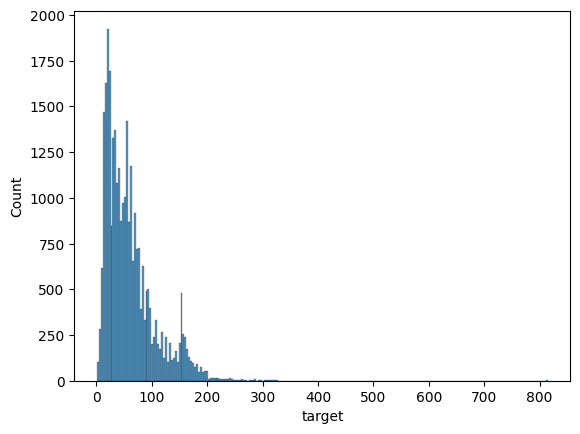

In [6]:
sns.histplot(data = df, x = "target")

<Axes: xlabel='target', ylabel='Count'>

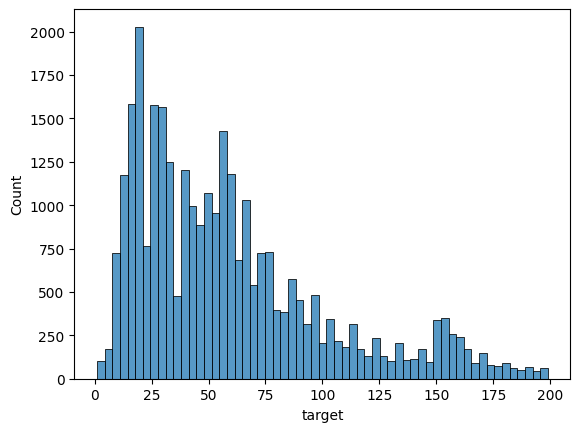

In [10]:
sns.histplot(data = df.query("target < 200"), x = "target")

## 2. Feature selection

In [5]:
features = ['Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       "L3_NO2_tropospheric_NO2_column_number_density",
       "L3_O3_O3_column_number_density",
       "L3_CO_CO_column_number_density",
       "L3_CO_H2O_column_number_density",
       "L3_HCHO_tropospheric_HCHO_column_number_density",
       "L3_SO2_SO2_column_number_density_amf"]

In [6]:
df = df[features]

### 2.1 Dealing with missing values

In [8]:
df[["L3_NO2_tropospheric_NO2_column_number_density",
       "L3_O3_O3_column_number_density",
       "L3_CO_CO_column_number_density",
       "L3_CO_H2O_column_number_density",
       "L3_HCHO_tropospheric_HCHO_column_number_density",
       "L3_SO2_SO2_column_number_density_amf"]].fillna(method="ffill", limit=1).isna().sum()

L3_NO2_tropospheric_NO2_column_number_density      4293
L3_O3_O3_column_number_density                      153
L3_CO_CO_column_number_density                     1619
L3_CO_H2O_column_number_density                    1619
L3_HCHO_tropospheric_HCHO_column_number_density    3329
L3_SO2_SO2_column_number_density_amf               3229
dtype: int64

<Axes: >

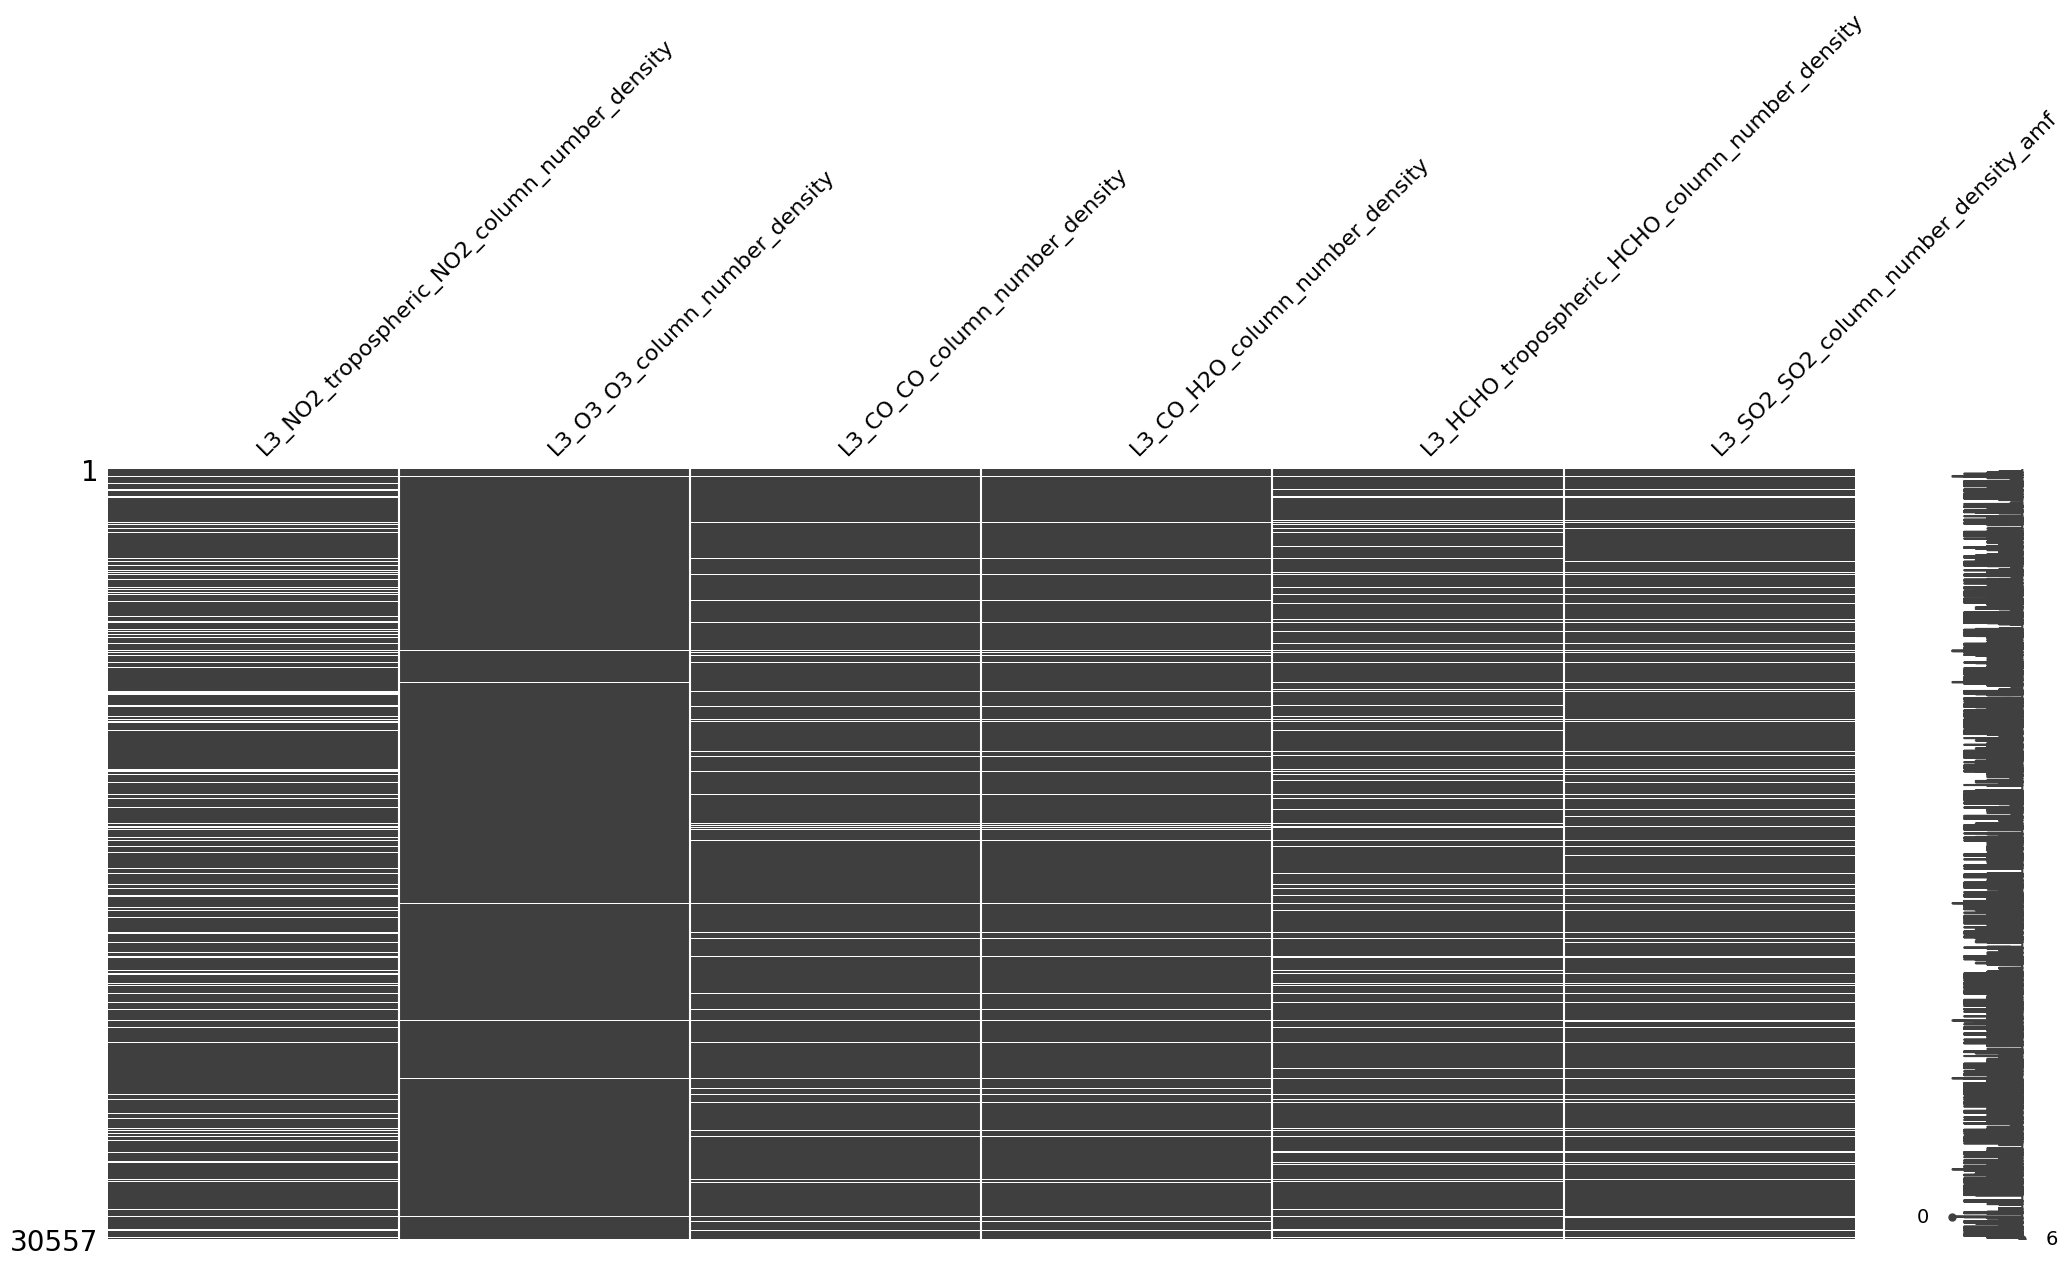

In [14]:
msno.matrix(df[["Place_ID","L3_NO2_tropospheric_NO2_column_number_density",
       "L3_O3_O3_column_number_density",
       "L3_CO_CO_column_number_density",
       "L3_CO_H2O_column_number_density",
       "L3_HCHO_tropospheric_HCHO_column_number_density",
       "L3_SO2_SO2_column_number_density_amf"]].groupby("Place_ID").fillna(method="ffill", limit=1))

## 3. Numerical correlations

In [9]:
numerical_cols = df.select_dtypes(include=['number']).columns

In [16]:
lst = []
for row in range(0,16):
    p = pd.concat([df, windspeed(df)], axis = 1).drop(["u_component_of_wind_10m_above_ground",
                                                      "v_component_of_wind_10m_above_ground"], axis = 1).groupby("Place_ID").corr(numeric_only=True).iloc[row::16,].mean()
    lst.append(p)
num_corrs = pd.DataFrame(np.array(lst), columns= ['target', 'target_min', 'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_CO_CO_column_number_density',
       'L3_CO_H2O_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_SO2_SO2_column_number_density_amf', 'windspeed'],
       index = ['target', 'target_min', 'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_CO_CO_column_number_density',
       'L3_CO_H2O_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_SO2_SO2_column_number_density_amf', 'windspeed'])

num_corrs

,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,temperature_2m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density,L3_SO2_SO2_column_number_density_amf,windspeed
target,1.000000,0.737864,0.625926,0.296235,0.138590,-0.100326,-0.036067,-0.057309,0.258884,0.316589,-0.073001,0.152557,0.018152,0.157642,-0.094910,-0.303554
target_min,0.737864,1.000000,0.427232,-0.010228,0.030045,-0.100663,-0.032414,-0.078064,0.196286,0.239987,-0.050553,0.137354,0.010696,0.126478,-0.063789,-0.232270
target_max,0.625926,0.427232,1.000000,0.699557,0.154466,-0.097578,-0.037380,-0.070689,0.195117,0.250084,-0.061389,0.102973,-0.027290,0.119736,-0.089928,-0.228436
target_variance,0.296235,-0.010228,0.699557,1.000000,0.070159,-0.019716,-0.003286,-0.016617,0.091937,0.117260,-0.029034,0.040800,-0.019471,0.054147,-0.051248,-0.104091
target_count,0.138590,0.030045,0.154466,0.070159,1.000000,-0.041088,-0.008713,-0.022660,0.018816,0.032003,-0.030115,0.005580,-0.011414,0.007315,-0.019090,-0.069138
precipitable_water_entire_atmosphere,-0.100326,-0.100663,-0.097578,-0.019716,-0.041088,1.000000,0.423246,0.528784,-0.108705,-0.196129,-0.062970,-0.022029,0.561742,0.015578,0.129574,0.086842
relative_humidity_2m_above_ground,-0.036067,-0.032414,-0.037380,-0.003286,-0.008713,0.423246,1.000000,-0.087707,-0.017973,-0.049724,0.018846,-0.029503,0.175007,-0.086348,0.144321,-0.071289
temperature_2m_above_ground,-0.057309,-0.078064,-0.070689,-0.016617,-0.022660,0.528784,-0.087707,1.000000,-0.127227,-0.182403,-0.101429,-0.036530,0.376905,0.103134,0.053712,0.101128
L3_NO2_NO2_column_number_density,0.258884,0.196286,0.195117,0.091937,0.018816,-0.108705,-0.017973,-0.127227,1.000000,0.880127,0.216801,0.237951,0.074132,0.153823,-0.176301,-0.161248
L3_NO2_tropospheric_NO2_column_number_density,0.316589,0.239987,0.250084,0.117260,0.032003,-0.196129,-0.049724,-0.182403,0.880127,1.000000,0.141228,0.217013,0.000853,0.193656,-0.223874,-0.214013


<Axes: >

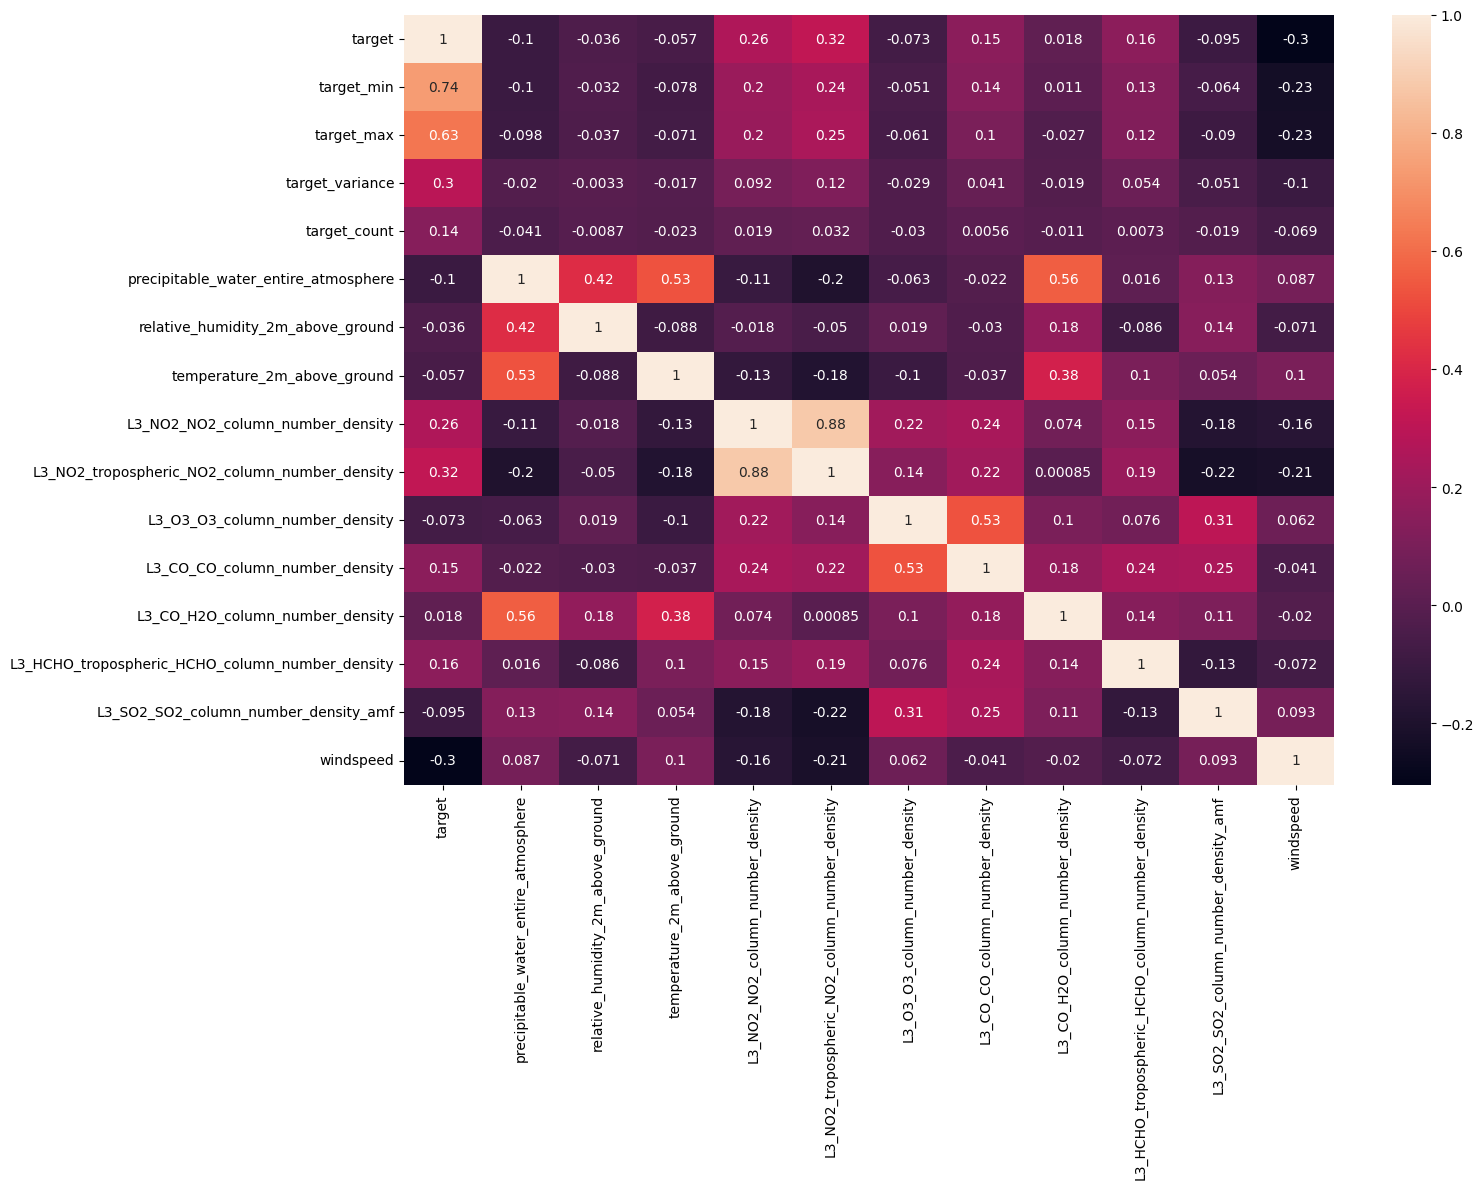

In [17]:
plt.figure(figsize = (15,10))
sns.heatmap(data = num_corrs.drop(["target_min","target_max", "target_variance","target_count"], axis = 1), annot=True)

<Axes: >

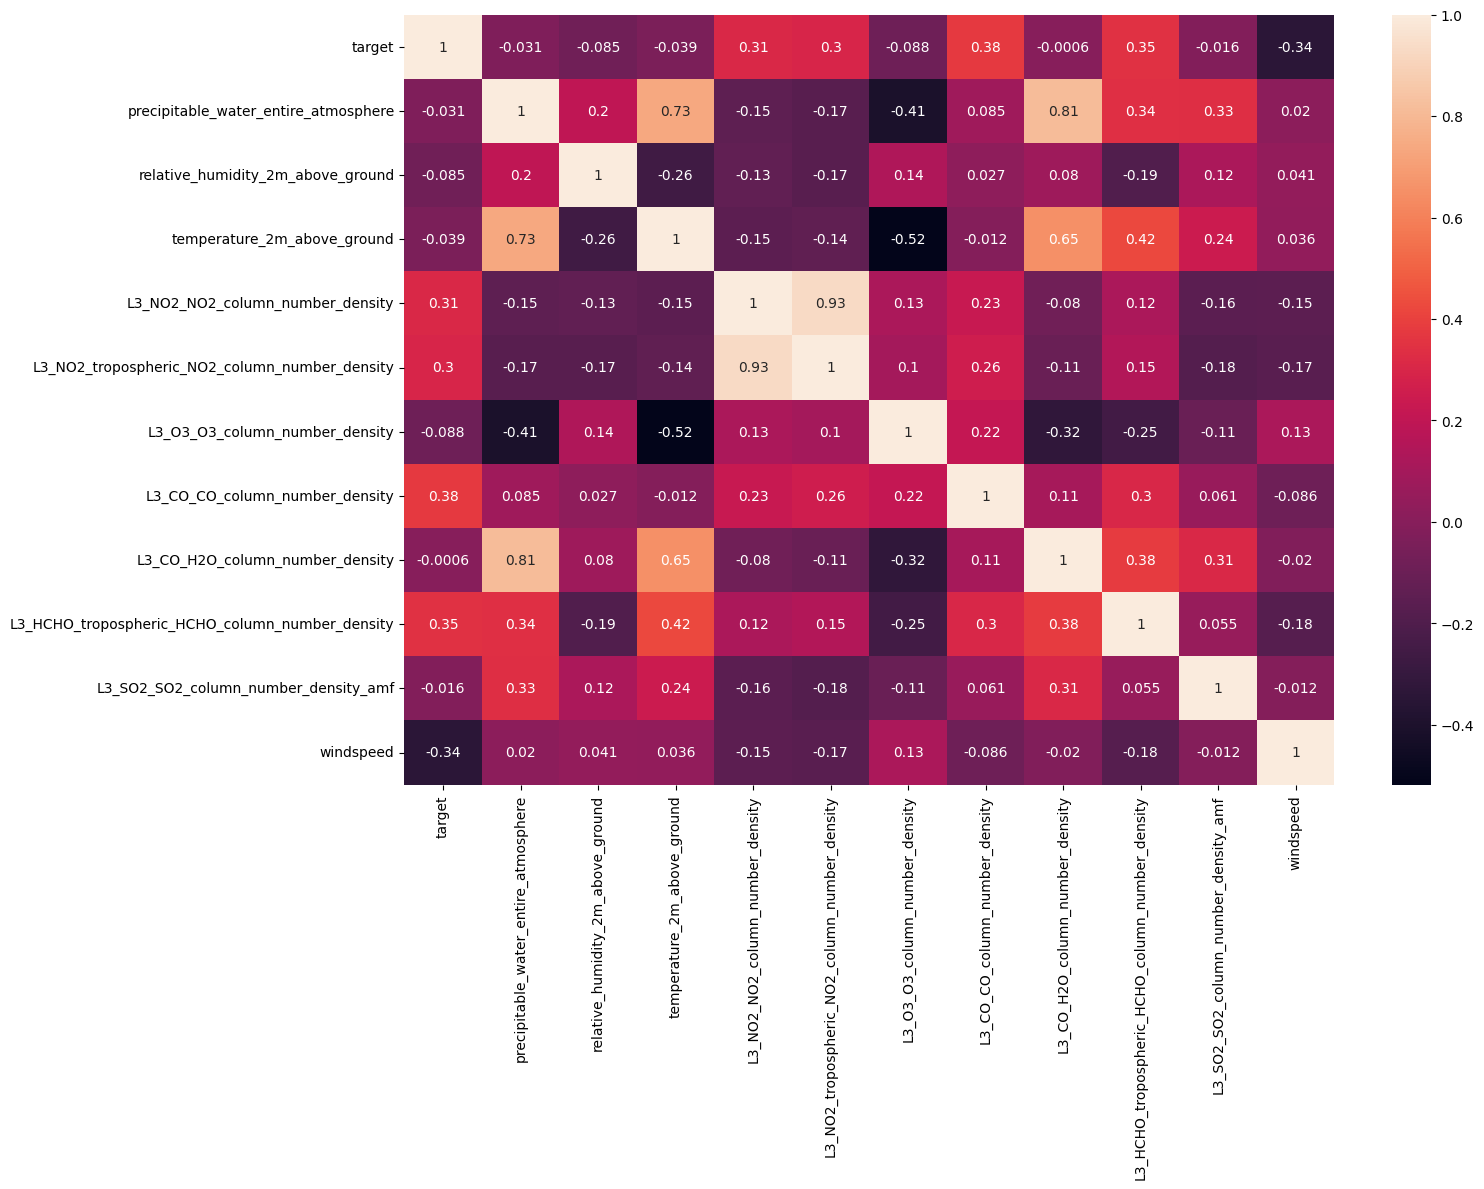

In [18]:
plt.figure(figsize = (15,10))
sns.heatmap(pd.concat([df, windspeed(df)], axis = 1).drop(["u_component_of_wind_10m_above_ground",
                                                "v_component_of_wind_10m_above_ground",
                                                "target_min","target_max", "target_variance","target_count"], axis = 1).corr(numeric_only=True), annot=True)

## 4. Feature engineering

In [7]:
df_n = df.copy()
df_n["target_prev"] = target_previous(df_n)
# df_n["target_class"] = target_class(df_n)
df_n["windspeed"] = windspeed(df_n)
df_n =df_n.dropna(subset=['target_prev'])
df_n

,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,temperature_2m_above_ground,...,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density,L3_SO2_SO2_column_number_density_amf,target_prev,windspeed
1,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,22.546533,...,-1.188108,0.000076,0.000021,0.115179,0.022017,1148.985447,0.000171,0.433957,38.0,3.536009
2,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,27.031030,...,3.500559,0.000067,0.000007,0.115876,0.020677,1109.347101,0.000124,0.356925,39.0,6.157557
3,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,23.971857,...,1.099468,0.000083,0.000023,0.141557,0.021207,1061.570832,0.000081,0.584522,24.0,3.198883
4,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,16.816309,...,2.670559,0.000070,0.000009,0.126369,0.037766,1044.247425,0.000140,0.408047,49.0,3.742413
5,2020-01-07,010Q650,28.0,10.0,52.0,1053.22,94,14.600000,42.200001,19.174890,...,0.969075,0.000069,0.000012,0.126138,0.029486,1503.566325,0.000094,0.441191,21.0,3.110417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30552,2020-03-15,YWSFY6Q,22.0,14.0,83.0,3848.86,72,6.700000,68.300003,4.256799,...,-4.195359,0.000063,0.000019,0.174995,0.039941,148.082862,0.000024,0.203573,22.0,6.383007
30553,2020-03-16,YWSFY6Q,53.0,30.0,146.0,9823.87,72,6.300000,77.700005,2.067438,...,0.749136,0.000072,0.000033,0.157659,0.037872,308.441747,-0.000014,0.234613,22.0,2.463107
30554,2020-03-17,YWSFY6Q,85.0,52.0,153.0,8900.85,72,7.100000,68.500000,4.438623,...,0.141943,0.000068,0.000025,0.168295,0.038539,673.059505,0.000094,0.263715,53.0,0.171193
30555,2020-03-18,YWSFY6Q,103.0,33.0,149.0,13963.90,72,19.100000,66.300003,10.573236,...,-1.439778,0.000086,0.000038,0.160637,0.038757,957.667555,0.000063,0.546447,85.0,1.504039


**Correlation between lagged target variable and target variable**

In [20]:
pd.concat([target_previous(df), df["target"]], axis = 1).dropna().corr().iloc[1,0]

0.847244701723005

In [21]:
pd.concat([df["Place_ID"],target_previous(df), df["target"]], axis = 1).dropna().groupby("Place_ID").corr().iloc[0::2,-1].mean()

0.5610492816403475

<Axes: xlabel='target', ylabel='Count'>

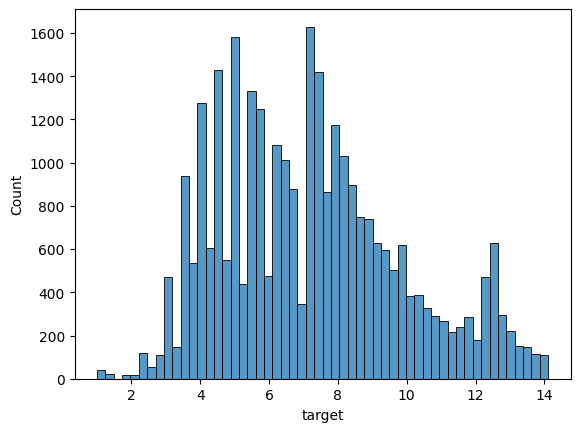

In [22]:
sns.histplot(x = np.sqrt(df.query("target < 200")["target"]))

## 5. Model preprocessing

In [8]:
train, test =train_test_split(df_n, test_size =0.3, random_state =21, stratify=df_n['Place_ID'])
train = train.query("target < 200")
test = test.query("target < 200")

In [9]:
wea_feat =["relative_humidity_2m_above_ground","temperature_2m_above_ground", "precipitable_water_entire_atmosphere", "windspeed"]
pollutants = ["L3_NO2_tropospheric_NO2_column_number_density", 'L3_CO_CO_column_number_density', 'L3_HCHO_tropospheric_HCHO_column_number_density']
rem_feat =['target_prev']
place = ["Place_ID"] 
X_train =train[place + rem_feat+wea_feat + pollutants]
y_train =train['target']
X_test =test[place  + rem_feat+wea_feat + pollutants]
y_test =test['target']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20973, 9), (20973,), (8983, 9), (8983,))

In [13]:
X_train

,Place_ID,target_prev,relative_humidity_2m_above_ground,temperature_2m_above_ground,precipitable_water_entire_atmosphere,windspeed,L3_NO2_tropospheric_NO2_column_number_density,L3_CO_CO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density
27688,UXIIFC9,34.0,47.100002,1.269891,4.700000,1.739846,0.000046,0.040481,0.000045
982,0RYZQUU,86.0,52.200001,22.052850,31.700001,2.440325,0.000030,0.047891,0.000167
2428,1YXF6T3,137.0,86.814290,8.505923,19.028572,1.648121,NaN,NaN,NaN
19943,LVBKULK,21.0,69.760002,4.577902,12.002373,5.471992,0.000052,NaN,-0.000031
27402,UNO965G,59.0,67.370003,11.044342,13.950001,1.091198,0.000029,0.035767,0.000030
...,...,...,...,...,...,...,...,...,...
23547,R8CIARR,151.0,75.900002,8.754449,16.600000,2.085570,0.000039,0.033348,0.000127
2420,1YXF6T3,74.0,74.528570,3.496524,7.100000,3.248302,NaN,0.033135,-0.000072
3661,35YN53B,34.0,68.300003,1.825525,12.600000,2.988710,NaN,0.033235,0.000045
25662,T6AW5VC,13.0,49.000000,-3.787085,3.600000,6.823191,0.000126,0.028659,0.000069


In [10]:
rem_tr =Pipeline(
  steps=[
    ("scaling", RobustScaler())
])

cat_tr =Pipeline(steps=[
 ("ohe", OneHotEncoder(drop='first',sparse_output=False))
])

wea_int =Pipeline(steps=[
  ("robust_scaler", RobustScaler()),
  ("polyint",PolynomialFeatures(2,interaction_only=True,include_bias=False))
])

pollutant_transf = Pipeline(
    steps = [
        ("forward_fill", FunctionTransformer(func=forw_fill_na)),
        ("knn_impute", KNNImputer(n_neighbors=5)),
        ("scaling", RobustScaler())
    ]
)

prepro =ColumnTransformer(
  transformers=[
    ("weather_interaction",  wea_int,  wea_feat),
    ("pollutant_transf", pollutant_transf, pollutants),
    ("rem_tranform", rem_tr, rem_feat)
])

prepro.set_output(transform="pandas")
prepro.fit_transform(X_train)



c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,weather_interaction__relative_humidity_2m_above_ground,weather_interaction__temperature_2m_above_ground,weather_interaction__precipitable_water_entire_atmosphere,weather_interaction__windspeed,weather_interaction__relative_humidity_2m_above_ground temperature_2m_above_ground,weather_interaction__relative_humidity_2m_above_ground precipitable_water_entire_atmosphere,weather_interaction__relative_humidity_2m_above_ground windspeed,weather_interaction__temperature_2m_above_ground precipitable_water_entire_atmosphere,weather_interaction__temperature_2m_above_ground windspeed,weather_interaction__precipitable_water_entire_atmosphere windspeed,pollutant_transf__L3_NO2_tropospheric_NO2_column_number_density,pollutant_transf__L3_CO_CO_column_number_density,pollutant_transf__L3_HCHO_tropospheric_HCHO_column_number_density,rem_tranform__target_prev
27688,-1.009723,-0.557099,-0.628099,-0.315383,0.562515,0.634206,0.318450,0.349913,0.175700,0.198092,0.166325,0.594526,-0.322571,-0.301887
982,-0.818998,1.040978,1.603306,-0.050892,-0.852559,-1.313104,0.041680,1.669007,-0.052977,-0.081595,-0.142286,1.490722,0.891713,0.679245
2428,0.475478,-0.000694,0.556080,-0.350018,-0.000330,0.264404,-0.166426,-0.000386,0.000243,-0.194638,-0.142286,1.490722,0.891713,1.641509
19943,-0.162304,-0.302734,-0.024597,1.093825,0.049135,0.003992,-0.177532,0.007446,-0.331138,-0.026905,0.289624,-0.367489,-1.070592,-0.547170
27402,-0.251683,0.194494,0.136364,-0.560304,-0.048951,-0.034320,0.141019,0.026522,-0.108976,-0.076405,-0.164081,0.024350,-0.470029,0.169811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23547,0.067315,0.018416,0.355372,-0.184843,0.001240,0.023922,-0.012443,0.006545,-0.003404,-0.065688,0.038202,-0.268206,0.493953,1.905660
2420,0.016027,-0.385885,-0.429752,0.254190,-0.006185,-0.006888,0.004074,0.165835,-0.098088,-0.109238,0.038202,-0.293877,-1.474401,0.452830
3661,-0.216903,-0.514374,0.024793,0.156171,0.111569,-0.005378,-0.033874,-0.012753,-0.080330,0.003872,0.389710,-0.281837,-0.322717,-0.301887
25662,-0.938669,-0.945948,-0.719008,1.604019,0.887932,0.674910,-1.505643,0.680144,-1.517319,-1.153303,1.726143,-0.835283,-0.079623,-0.698113


## 6. Model Estimation

**Baseline Model**

In [13]:
y_train_pred =X_train['target_prev']
y_test_pred =X_test['target_prev']
print("R2 on train set for baseline:", round(r2_score(y_train, y_train_pred), 2),"\n")
print("MSE on train set for baseline", mean_squared_error(y_train, y_train_pred),"\n")

R2 on train set for baseline: 0.69 

MSE on train set for baseline 555.8489305297287 



**Elastic Net Regression**

In [14]:
elas_net =Pipeline(
  steps = [
      ("feature_eng", prepro),
      ("elastic_net", ElasticNet())
      ])
  
#transf_y = Pipeline(
   # steps = [
    #("log_transf", FunctionTransformer(func=np.sqrt, inverse_func=np.power(2)))])
# below in the TransformedTargetRegressor, StandardScaler() is applied, 
# but inverse transform happens automatically when .predict is called on X_train/X_test 
# so it reverts back to original units.

#elas_net_transf = TransformedTargetRegressor(regressor=elas_net, transformer=transf_y)

In [16]:
elas_net.fit(X_train, y_train)

Pipeline(steps=[('feature_eng',
                 ColumnTransformer(transformers=[('weather_interaction',
                                                  Pipeline(steps=[('robust_scaler',
                                                                   RobustScaler()),
                                                                  ('polyint',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['relative_humidity_2m_above_ground',
                                                   'temperature_2m_above_ground',
                                                   'precipitable_water_entire_atmosphere',
                                                   'windspeed']),
                                                 ('pollutant_transf',...
                                                                   FunctionTransformer(func=<function forw_fill_na at 0x000001CE88CA5760>)),
                                                                  ('knn_impute',
                                                                   KNNImputer()),
                                                                  ('scaling',
                                                                   RobustScaler())]),
                                                  ['L3_NO2_tropospheric_NO2_column_number_density',
                                                   'L3_CO_CO_column_number_density',
                                                   'L3_HCHO_tropospheric_HCHO_column_number_density']),
                                                 ('rem_tranform',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['target_prev'])])),
                ('elastic_net', ElasticNet())])

In [19]:
y_train_pred_elas_net = elas_net.predict(X_train)
print("Mean Absolute Percentage Error on TRAIN set for Elastic Net:", mean_absolute_percentage_error(y_train, y_train_pred_elas_net),"\n")
print("R2 on TRAIN set for Elastic Net:",  r2_score(y_train, y_train_pred_elas_net),"\n")
print("Adj. R2 on TRAIN set for Elastic Net:",  adjusted_r_squared(r2_score(y_train, y_train_pred_elas_net),X_train),"\n")

Mean Absolute Percentage Error on TRAIN set for Elastic Net: 0.5950723661847577 

R2 on TRAIN set for Elastic Net: 0.6418660820353179 

Adj. R2 on TRAIN set for Elastic Net: 0.6417123251655148 



**Random Forest Regression**

In [15]:
pollutant_transf_rand_forest = Pipeline(
    steps = [
        ("forward_fill", FunctionTransformer(func=forw_fill_na)),
        ("knn_impute", KNNImputer(n_neighbors=5))
    ]
)

cat_tr =Pipeline(steps=[
 ("ohe", OneHotEncoder(drop='first',sparse_output=False))
])


prepro_rand_forest = ColumnTransformer(
  transformers=[
    ("pollutant_transf", pollutant_transf, pollutants),
    ("dummy_categorical", cat_tr, place)
    ],
    remainder="passthrough")

prepro_rand_forest.set_output(transform="pandas")
prepro_rand_forest.fit_transform(X_train)

c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,pollutant_transf__L3_NO2_tropospheric_NO2_column_number_density,pollutant_transf__L3_CO_CO_column_number_density,pollutant_transf__L3_HCHO_tropospheric_HCHO_column_number_density,dummy_categorical__Place_ID_05EC30X,dummy_categorical__Place_ID_0DPWHX8,dummy_categorical__Place_ID_0GBXTHY,dummy_categorical__Place_ID_0HYPV1N,dummy_categorical__Place_ID_0I2XREH,dummy_categorical__Place_ID_0KV6RJ1,dummy_categorical__Place_ID_0MGEY68,dummy_categorical__Place_ID_0O9R6AD,dummy_categorical__Place_ID_0PP73FZ,dummy_categorical__Place_ID_0RYZQUU,dummy_categorical__Place_ID_0TFOCOS,dummy_categorical__Place_ID_0TLH9UN,dummy_categorical__Place_ID_11WPGRD,dummy_categorical__Place_ID_168B2T2,dummy_categorical__Place_ID_1GZGJPN,dummy_categorical__Place_ID_1LC5FAK,dummy_categorical__Place_ID_1PRBF5P,dummy_categorical__Place_ID_1RYCZPT,dummy_categorical__Place_ID_1SC5AWD,dummy_categorical__Place_ID_1SKLTGJ,dummy_categorical__Place_ID_1TE1HKJ,dummy_categorical__Place_ID_1UEYEJQ,dummy_categorical__Place_ID_1VN0K1S,dummy_categorical__Place_ID_1WD100Y,dummy_categorical__Place_ID_1X421B8,dummy_categorical__Place_ID_1Y0S7TZ,dummy_categorical__Place_ID_1YXF6T3,dummy_categorical__Place_ID_1Z0FIHB,dummy_categorical__Place_ID_1ZBVIMD,dummy_categorical__Place_ID_215BUAP,dummy_categorical__Place_ID_22D7H7I,dummy_categorical__Place_ID_238N4KU,dummy_categorical__Place_ID_28OSFYU,dummy_categorical__Place_ID_2JZW8ZM,dummy_categorical__Place_ID_2OR3E6X,dummy_categorical__Place_ID_2S8UY1N,dummy_categorical__Place_ID_2T41T7C,dummy_categorical__Place_ID_2USU80I,dummy_categorical__Place_ID_2WABRKJ,dummy_categorical__Place_ID_35YN53B,dummy_categorical__Place_ID_37VXILV,dummy_categorical__Place_ID_3EJ33BJ,dummy_categorical__Place_ID_3H1DEPM,dummy_categorical__Place_ID_3HTVI1M,dummy_categorical__Place_ID_3MXSVYJ,dummy_categorical__Place_ID_3V177MC,dummy_categorical__Place_ID_3WZQJU8,dummy_categorical__Place_ID_4085G7L,dummy_categorical__Place_ID_426FKUG,dummy_categorical__Place_ID_431JQGO,dummy_categorical__Place_ID_4EVR9T8,dummy_categorical__Place_ID_4IVJPF2,dummy_categorical__Place_ID_4WA4C0T,dummy_categorical__Place_ID_4XP6UOX,dummy_categorical__Place_ID_4ZMC9UQ,dummy_categorical__Place_ID_50JFNAG,dummy_categorical__Place_ID_57GIW0H,dummy_categorical__Place_ID_5ETAG9S,dummy_categorical__Place_ID_5I4TI4R,dummy_categorical__Place_ID_5IOL334,dummy_categorical__Place_ID_5IUK9TG,dummy_categorical__Place_ID_5KE9R9R,dummy_categorical__Place_ID_5M7ZX94,dummy_categorical__Place_ID_5QYHA81,dummy_categorical__Place_ID_5SXR1G0,dummy_categorical__Place_ID_5YBO7PQ,dummy_categorical__Place_ID_62HOUYZ,dummy_categorical__Place_ID_693EWQR,dummy_categorical__Place_ID_6CR3BYP,dummy_categorical__Place_ID_6HXPCBH,dummy_categorical__Place_ID_6J4AKCJ,dummy_categorical__Place_ID_6KAHP8X,dummy_categorical__Place_ID_6KHIOQ8,dummy_categorical__Place_ID_6O56XQX,dummy_categorical__Place_ID_6PWJJ6D,dummy_categorical__Place_ID_6SJG8N2,dummy_categorical__Place_ID_6TF1KNR,dummy_categorical__Place_ID_6TLEFED,dummy_categorical__Place_ID_6U70TX5,dummy_categorical__Place_ID_73GXFXK,dummy_categorical__Place_ID_7DRFQCK,dummy_categorical__Place_ID_7LG0EUH,dummy_categorical__Place_ID_7MO7ONT,dummy_categorical__Place_ID_7NG0HSJ,dummy_categorical__Place_ID_7YE6PEV,dummy_categorical__Place_ID_89GCPDD,dummy_categorical__Place_ID_8D88XH3,dummy_categorical__Place_ID_8HLVCJG,dummy_categorical__Place_ID_8ISJ2N4,dummy_categorical__Place_ID_8OBB7UJ,dummy_categorical__Place_ID_8YYQSD3,dummy_categorical__Place_ID_8ZGB2UV,dummy_categorical__Place_ID_8ZSYE9O,dummy_categorical__Place_ID_90AJCJ1,dummy_categorical__Place_ID_92A8XLV,dummy_categorical__Place_ID_96GO3YA,dummy_categorical__Place_ID_99IA3IO,dummy_categorical__Place_ID_9BJURTV,dummy_categorical__Place_ID_9NOGUM2,dummy_categorical__Place_ID_9YWJ0T2,dummy_categorical__Place_ID_A0U3M42,dummy_categorical__Place_ID_A6F2SYU,dummy_categorical__Place_ID_A8RN00Y,dummy_categorical__Place_ID_AAXHBW0,dummy_categorical__Place_ID_AKPYCSK,dummy_categorical__Place_ID_ARTRJ6I,dumm

In [16]:
rand_for =Pipeline(
  steps = [
      ("feature_eng", prepro_rand_forest),
      ("random_forest", RandomForestRegressor())])

In [22]:
rand_for.fit(X_train,y_train)

Mean Squared Error on train set for Random Forests: 51.28 

R2 on train set for Random Forests: 0.9713560899510492 



In [23]:
y_train_pred_rand_for = rand_for.predict(X_train)

print("Mean Squared Error on train set for Random Forests:", round(mean_squared_error(y_train, y_train_pred_rand_for), 2),"\n")
print("R2 on train set for Random Forests:", r2_score(y_train, y_train_pred_rand_for),"\n")
print("Adj. R2 on TRAIN set for Random Forests:",  adjusted_r_squared(r2_score(y_train, y_train_pred_rand_for),X_train),"\n")

Mean Squared Error on train set for Random Forests: 51.28 

R2 on train set for Random Forests: 0.9713560899510492 

Adj. R2 on TRAIN set for Random Forests: 0.971343792322349 



**XGBoost Regression**

In [14]:
prepro_xgb = ColumnTransformer(
  transformers=[
    ("dummy_categorical", cat_tr, place)
    ],
    remainder="passthrough")

In [15]:
xgb =Pipeline(
  steps = [
      ("feature_eng", prepro_xgb),
      ("XGB", XGBRegressor(use_label_encoder=False))])

In [ ]:
xgb.fit(X_train,y_train)

y_train_pred_xgb = xgb.predict(X_train)

print("Mean Squared Error on train set for XGBoost:", round(mean_squared_error(y_train, y_train_pred_xgb), 2),"\n")
print("R2 on train set for XGBoost:", r2_score(y_train, y_train_pred_xgb),"\n")
print("Adj. R2 on TRAIN set for XGBoost:",  adjusted_r_squared(r2_score(y_train, y_train_pred_xgb),X_train),"\n")

<Axes: >

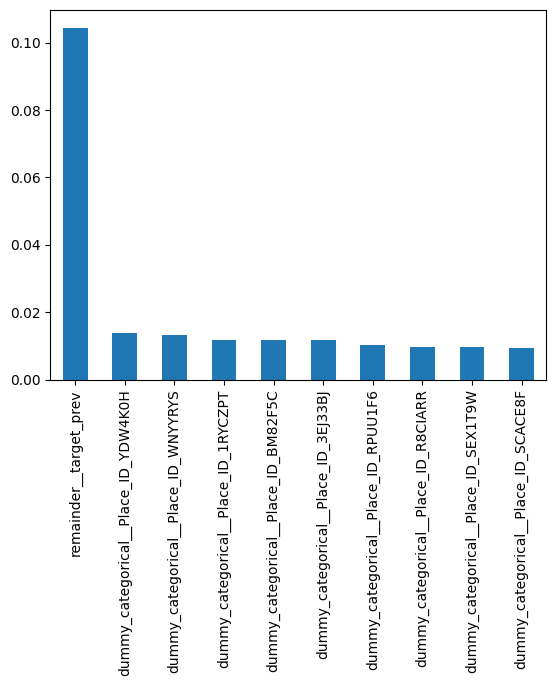

In [50]:
feature_imp = pd.DataFrame(xgb.steps[1][1].feature_importances_, index = xgb.steps[0][1].get_feature_names_out()).sort_values(by = 0, ascending=False).head(10) 
feature_imp.plot.bar(legend = False)

### 6.1 Cross-validation

**Elastic Net Regression**

In [38]:
cv_elas_net = cross_validate(estimator=elas_net, X=X_train, y=y_train, cv = 5, n_jobs=-1, 
               scoring = ["r2","neg_mean_squared_error","neg_mean_absolute_percentage_error"], return_train_score=True)
pd.DataFrame(cv_elas_net).describe()

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,6.834844,1.547095,0.641311,0.641779,-642.134258,-641.217911,-0.595405,-0.595152
std,0.219816,0.110083,0.004816,0.002817,34.510589,4.801781,0.006371,0.002452
min,6.505746,1.485268,0.636227,0.638093,-697.528430,-645.005656,-0.603060,-0.598245
25%,6.762729,1.496364,0.636503,0.640100,-651.067096,-644.929366,-0.599939,-0.596892
50%,6.899661,1.503461,0.641981,0.641639,-632.350996,-644.215718,-0.594032,-0.595096
75%,6.905609,1.506920,0.645276,0.644251,-618.886742,-636.083558,-0.593375,-0.592921
max,7.100476,1.743460,0.646569,0.644811,-610.838029,-635.855257,-0.586619,-0.592608


**Random Forest**

In [39]:
cv_rand_for = cross_validate(estimator=rand_for, X=X_train, y=y_train, cv = 5, n_jobs=-1, 
               scoring = ["r2","neg_mean_squared_error","neg_mean_absolute_percentage_error"], return_train_score=True)
pd.DataFrame(cv_rand_for).describe()

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,101.800160,2.100660,0.791908,0.970870,-372.436652,-52.145211,-0.315136,-0.116451
std,1.338337,0.443524,0.003214,0.000209,17.697732,0.587029,0.009191,0.000457
min,100.055188,1.466702,0.786325,0.970659,-397.917931,-53.120201,-0.330708,-0.116823
25%,101.217379,1.937499,0.792440,0.970666,-382.426670,-52.177802,-0.314792,-0.116819
50%,101.519969,2.090613,0.792636,0.970882,-367.118384,-51.956780,-0.312715,-0.116553
75%,102.716292,2.376823,0.794061,0.971007,-360.589402,-51.902570,-0.310655,-0.116345
max,103.491971,2.631662,0.794076,0.971133,-354.130872,-51.568701,-0.306810,-0.115716


**XGBoost Regression**

In [40]:
cv_xgb = cross_validate(estimator=xgb, X=X_train, y=y_train, cv = 5, n_jobs=-1, 
               scoring = ["r2","neg_mean_squared_error",
               "neg_mean_absolute_error","neg_mean_absolute_percentage_error"], return_train_score=True)
pd.DataFrame(cv_xgb).describe()

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.167893,0.054854,0.802261,0.894979,-354.108523,-187.989424,-13.041698,-9.773465,-0.314037,-0.251571
std,0.050968,0.024316,0.004128,0.001382,22.172757,2.623865,0.299725,0.052178,0.007647,0.001194
min,3.128037,0.040007,0.797977,0.893017,-387.669643,-191.709807,-13.461892,-9.836138,-0.324704,-0.252903
25%,3.140038,0.043998,0.798290,0.894221,-361.012834,-189.077744,-13.177665,-9.809729,-0.316527,-0.252796
50%,3.154111,0.045078,0.803221,0.895483,-349.206354,-188.117141,-13.016233,-9.770996,-0.313445,-0.251095
75%,3.161119,0.047079,0.804109,0.895587,-344.576204,-185.916527,-12.883172,-9.747460,-0.311916,-0.250657
max,3.256158,0.098107,0.807710,0.896589,-328.077580,-185.125899,-12.669528,-9.703002,-0.303593,-0.250403


### 6.2 Hyperparameter Tuning

**Elastic Net Regression**

In [11]:
scoring = {"R2":"r2", "MAPE":"neg_mean_absolute_percentage_error", "MSE":"neg_mean_squared_error"}

In [64]:
elas_net.get_params()

{'memory': None,
 'steps': [('feature_eng',
   ColumnTransformer(transformers=[('weather_interaction',
                                    Pipeline(steps=[('robust_scaler',
                                                     RobustScaler()),
                                                    ('polyint',
                                                     PolynomialFeatures(include_bias=False,
                                                                        interaction_only=True))]),
                                    ['relative_humidity_2m_above_ground',
                                     'temperature_2m_above_ground',
                                     'precipitable_water_entire_atmosphere',
                                     'windspeed']),
                                   ('pollutant_transf',
                                    Pipeline(steps=[('forward_fill',
                                                     FunctionTransformer(func=<function forw_fill_na at 0x

In [68]:
params_elas_net = {"elastic_net__l1_ratio":np.linspace(0,1,20),
                   "elastic_net__alpha":np.linspace(0,1,20)}

In [92]:
elas_net_hyperpar = RandomizedSearchCV(estimator= elas_net, param_distributions=params_elas_net,
                                       scoring = scoring,
                                        cv = 5, n_jobs=-1, refit="MSE")

In [93]:
elas_net_hyperpar.fit(X_train, y_train)

c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.579e+06, tolerance: 3.754e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_eng',
                                              ColumnTransformer(transformers=[('weather_interaction',
                                                                               Pipeline(steps=[('robust_scaler',
                                                                                                RobustScaler()),
                                                                                               ('polyint',
                                                                                                PolynomialFeatures(include_bias=False,
                                                                                                                   interaction_only=True))]),
                                                                               ['relative_humidity_2m_above_ground',
                                                                                'temperature_2m_above_ground',
                                                                                'precipitable_water_entire_atmosphere',...
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                                        'elastic_net__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
                   refit='MSE',
                   scoring={'MAPE': 'neg_mean_absolute_percentage_error',
                            'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [94]:
elast_net_best = elas_net_hyperpar.best_estimator_
elas_net_hyperpar.best_params_

{'elastic_net__l1_ratio': 0.5263157894736842, 'elastic_net__alpha': 0.0}

In [95]:
y_train_pred_elas_net_best = elast_net_best.predict(X_train)
y_test_pred_elas_net_best = elast_net_best.predict(X_train)

print("TRAIN")
print("TUNED: Mean Absolute Percentage Error on TRAIN set for Elastic Net:", mean_absolute_percentage_error(y_train, y_train_pred_elas_net_best),"\n")
print("TUNED: R2 on TRAIN set for Elastic Net:",  r2_score(y_train, y_train_pred_elas_net_best),"\n")
print("TUNED: Adj. R2 on TRAIN set for Elastic Net:",  adjusted_r_squared(r2_score(y_train, y_train_pred_elas_net_best),X_train),"\n")

print("TEST")
print("TUNED: Mean Absolute Percentage Error on TEST set for Elastic Net:", mean_absolute_percentage_error(y_test, y_test_pred_elas_net_best),"\n")
print("TUNED: R2 on TEST set for Elastic Net:",  r2_score(y_test, y_test_pred_elas_net_best),"\n")
print("TUNED: Adj. R2 on TEST set for Elastic Net:",  adjusted_r_squared(r2_score(y_test, y_test_pred_elas_net_best),X_test),"\n")

TUNED: Mean Absolute Percentage Error on train set for Elastic Net: 0.5950723661847577 

TUNED: R2 on train set for Elastic Net: 0.7560658170568983 



**Random Forest Regression**

In [43]:
rand_for.get_params()

{'memory': None,
 'steps': [('feature_eng',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pollutant_transf',
                                    Pipeline(steps=[('forward_fill',
                                                     FunctionTransformer(func=<function forw_fill_na at 0x000001CA07665760>)),
                                                    ('knn_impute', KNNImputer()),
                                                    ('scaling', RobustScaler())]),
                                    ['L3_NO2_tropospheric_NO2_column_number_density',
                                     'L3_CO_CO_column_number_density',
                                     'L3_HCHO_tropospheric_HCHO_column_number_density']),
                                   ('dummy_categorical',
                                    Pipeline(steps=[('ohe',
                                                     OneHotEncoder(drop='first',
                                                

In [87]:
params_rand_for = {"random_forest__max_depth":np.arange(1,32,2),
          "random_forest__min_samples_split":np.arange(1,30,2),
          'random_forest__bootstrap':[True,False],
          'random_forest__max_leaf_nodes':np.arange(1,20,2)}

In [96]:
rand_for_hyperpar = RandomizedSearchCV(estimator= rand_for, param_distributions=params_rand_for,
                                       scoring = scoring,
                                        cv = 5, n_jobs=-1, refit="MSE")

In [97]:
rand_for_hyperpar.fit(X_train, y_train)

c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_eng',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pollutant_transf',
                                                                               Pipeline(steps=[('forward_fill',
                                                                                                FunctionTransformer(func=<function forw_fill_na at 0x000001CA07665760>)),
                                                                                               ('knn_impute',
                                                                                                KNNImputer()),
                                                                                               ('scaling',
                                                                                                RobustScaler())]),
                                                                               ['L3_NO2_tropospheric_NO2_column_number_density',
                                                                                '...
                   param_distributions={'random_forest__bootstrap': [True,
                                                                     False],
                                        'random_forest__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]),
                                        'random_forest__max_leaf_nodes': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'random_forest__min_samples_split': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
                   refit='MSE',
                   scoring={'MAPE': 'neg_mean_absolute_percentage_error',
                            'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [98]:
rand_for_best = rand_for_hyperpar.best_estimator_
rand_for_hyperpar.best_params_

{'random_forest__min_samples_split': 13,
 'random_forest__max_leaf_nodes': 13,
 'random_forest__max_depth': 15,
 'random_forest__bootstrap': True}

In [99]:
y_train_pred_rand_for_best = rand_for_best.predict(X_train)
y_test_pred_rand_for_best = rand_for_best.predict(X_test)

print("TRAIN")
print("TUNED: Mean Absolute Percentage Error on TRAIN set for Random Forests:", round(mean_absolute_percentage_error(y_train, y_train_pred_rand_for_best), 2),"\n")
print("TUNED: R2 on TRAIN set for Random Forests:", r2_score(y_train, y_train_pred_rand_for_best),"\n")
print("TUNED: Adj. R2 on TRAIN set for Random Forests:",  adjusted_r_squared(r2_score(y_train, y_train_pred_rand_for_best),X_train),"\n")

print("TEST")
print("TUNED: Mean Absolute Percentage Error on TEST set for Random Forests:", round(mean_absolute_percentage_error(y_test, y_test_pred_rand_for_best), 2),"\n")
print("TUNED: R2 on TEST set for Random Forests:", r2_score(y_test, y_test_pred_rand_for_best),"\n")
print("TUNED: Adj. R2 on TEST set for Random Forests:",  adjusted_r_squared(r2_score(y_test, y_test_pred_rand_for_best),X_test),"\n")

TUNED: Mean Absolute Percentage Error on TRAIN set for Random Forests: 0.39 

TUNED: R2 on TRAIN set for Random Forests: 0.7597905287636563 

TUNED: Mean Absolute Percentage Error on TEST set for Random Forests: 0.41 

TUNED: R2 on TEST set for Random Forests: 0.7493484174081144 



**XGBoost Regressor**

In [21]:
xgb.get_params()

{'memory': None,
 'steps': [('feature_eng',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('dummy_categorical',
                                    Pipeline(steps=[('ohe',
                                                     OneHotEncoder(drop='first',
                                                                   sparse_output=False))]),
                                    ['Place_ID'])])),
  ('XGB',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_l

In [12]:
params_xgb = {"XGB__n_estimators":np.arange(1,310,10),
              "XGB__max_depth":np.arange(1,10,1),
          'XGB__subsample': np.arange(0.5, 1.1, 0.1),
           "XGB__colsample_bytree":np.arange(0.5, 1.1, 0.1),
          "XGB__learning_rate": np.linspace(0,1,100),
          "XGB__gamma":np.linspace(0,100,20),
         }

In [41]:
xgb_hyperpar = RandomizedSearchCV(estimator= xgb, param_distributions=params_xgb,
                                       scoring = scoring, n_iter = 30,
                                        cv = 5, n_jobs=-1, refit="R2")

In [42]:
xgb_hyperpar.fit(X_train, y_train)

c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.ve

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_eng',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('dummy_categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Place_ID'])])),
                                             ('XGB',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsampl...
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'XGB__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'XGB__n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301]),
                                        'XGB__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])},
                   refit='R2',
                   scoring={'MAPE': 'neg_mean_absolute_percentage_error',
                            'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [43]:
xgb_best = xgb_hyperpar.best_estimator_
xgb_hyperpar.best_params_

{'XGB__subsample': 0.7999999999999999,
 'XGB__n_estimators': 201,
 'XGB__max_depth': 3,
 'XGB__learning_rate': 0.4141414141414142,
 'XGB__gamma': 26.315789473684212,
 'XGB__colsample_bytree': 0.5}

In [44]:
y_train_pred_xgb_best = xgb_best.predict(X_train)
y_test_pred_xgb_best = xgb_best.predict(X_test)

print("TRAIN")
print("TUNED: Mean Absolute Percentage Error on TRAIN set for XGBoost:", round(mean_absolute_percentage_error(y_train, y_train_pred_xgb_best), 2),"\n")
print("TUNED: R2 on TRAIN set for XGBoost:", round(r2_score(y_train, y_train_pred_xgb_best),2),"\n")
print("TUNED: Adj. R2 on TRAIN set for XGBoost:",  round(adjusted_r_squared(r2_score(y_train, y_train_pred_xgb_best),X_train),2),"\n")

print("")
print("TEST")
print("TUNED: Mean Absolute Percentage Error on TEST set for XGBoost:", round(mean_absolute_percentage_error(y_test, y_test_pred_xgb_best), 2),"\n")
print("TUNED: R2 on TEST set for XGBoost:", round(r2_score(y_test, y_test_pred_xgb_best),2),"\n")
print("TUNED: Adj. R2 on TEST set for XGBoost:",  round(adjusted_r_squared(r2_score(y_test, y_test_pred_xgb_best),X_test),2),"\n")

TRAIN
TUNED: Mean Absolute Percentage Error on TRAIN set for XGBoost: 0.29 

TUNED: R2 on TRAIN set for XGBoost: 0.85 

TUNED: Adj. R2 on TRAIN set for XGBoost: 0.85 


TEST
TUNED: Mean Absolute Percentage Error on TEST set for XGBoost: 0.32 

TUNED: R2 on TEST set for XGBoost: 0.81 

TUNED: Adj. R2 on TEST set for XGBoost: 0.81 



In [45]:
feature_imp = pd.DataFrame(xgb_best.steps[1][1].feature_importances_, index = xgb_best.steps[0][1].get_feature_names_out()).sort_values(by = 0, ascending=False).head(10) 

In [46]:
feature_imp

,0
remainder__target_prev,0.230119
dummy_categorical__Place_ID_EE8C6RP,0.036828
remainder__windspeed,0.025739
dummy_categorical__Place_ID_CX6SRPO,0.011338
remainder__L3_CO_CO_column_number_density,0.010769
remainder__L3_HCHO_tropospheric_HCHO_column_number_density,0.007511
dummy_categorical__Place_ID_R8CIARR,0.007299
remainder__temperature_2m_above_ground,0.007222
dummy_categorical__Place_ID_D1OBVR6,0.007196
dummy_categorical__Place_ID_QO3SZZ5,0.007017


In [27]:
feature_imp.index = ["PM2.5 day before","City 1",
                     "City 2", "City 3", "City 4",
                     "City 5","City 6","City 7",
                     "City 8","City 9"]

<Axes: >

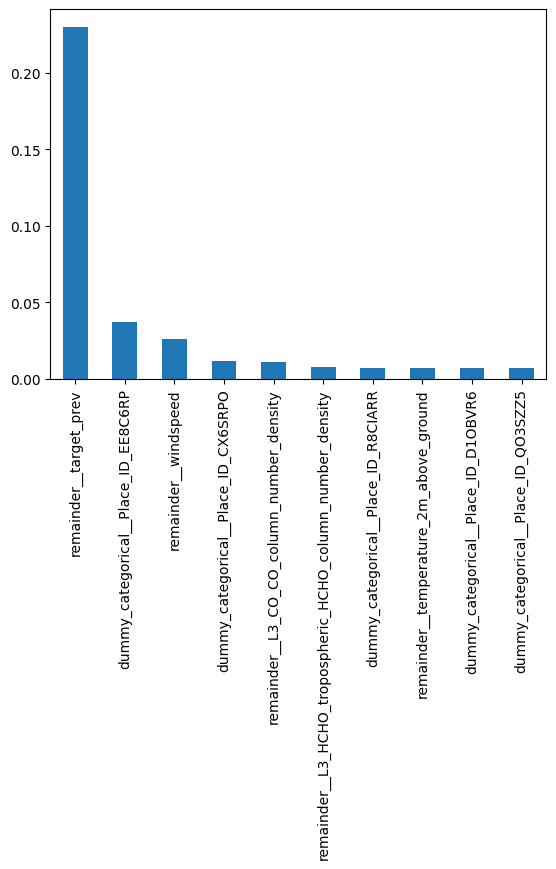

In [47]:
feature_imp.plot.bar(legend = False)

In [48]:
actual_pred_test = pd.DataFrame({"PM2_5":y_test, "PM2_5_predicted_XGB":y_test_pred_xgb_best}).eval("residuals = PM2_5 - PM2_5_predicted_XGB")

In [49]:
actual_pred_test

,PM2_5,PM2_5_predicted_XGB,residuals
28958,124.0,115.892403,8.107597
24885,13.0,10.845668,2.154332
5024,85.0,95.613846,-10.613846
24690,9.4,23.553301,-14.153301
11619,119.0,122.686073,-3.686073
...,...,...,...
10618,6.0,25.002441,-19.002441
19520,27.0,33.406570,-6.406570
28286,139.0,96.189987,42.810013
29752,13.0,21.612127,-8.612127


In [50]:
stsc = StandardScaler()
actual_pred_test["residuals"] = stsc.fit_transform(actual_pred_test[["residuals"]])
actual_pred_test

,PM2_5,PM2_5_predicted_XGB,residuals
28958,124.0,115.892403,0.422646
24885,13.0,10.845668,0.103331
5024,85.0,95.613846,-0.581515
24690,9.4,23.553301,-0.771360
11619,119.0,122.686073,-0.209930
...,...,...,...
10618,6.0,25.002441,-1.031453
19520,27.0,33.406570,-0.355850
28286,139.0,96.189987,2.283976
29752,13.0,21.612127,-0.474149


Text(0, 0.5, 'Standardized Residuals')

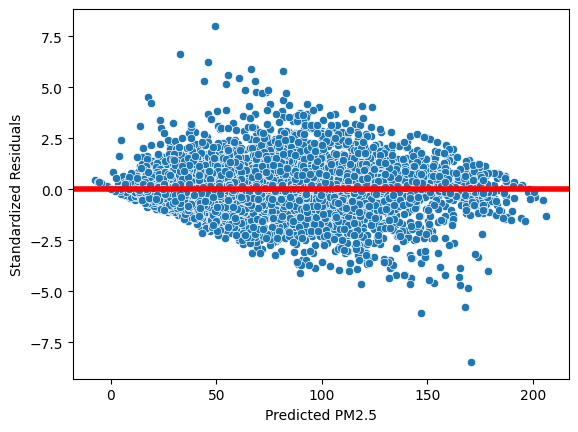

In [51]:
sns.scatterplot(data = actual_pred_test, x = "PM2_5_predicted_XGB", y = "residuals")
plt.axhline(0, color='red', linewidth = 4)
plt.xlabel("Predicted PM2.5")
plt.ylabel("Standardized Residuals")

(array([0, 1]),
 [Text(0, 0, 'WARNING: Bad Air quality (> 15mg/m3)'),
  Text(1, 0, 'Good Air Quality (< 15mg/m3)')])

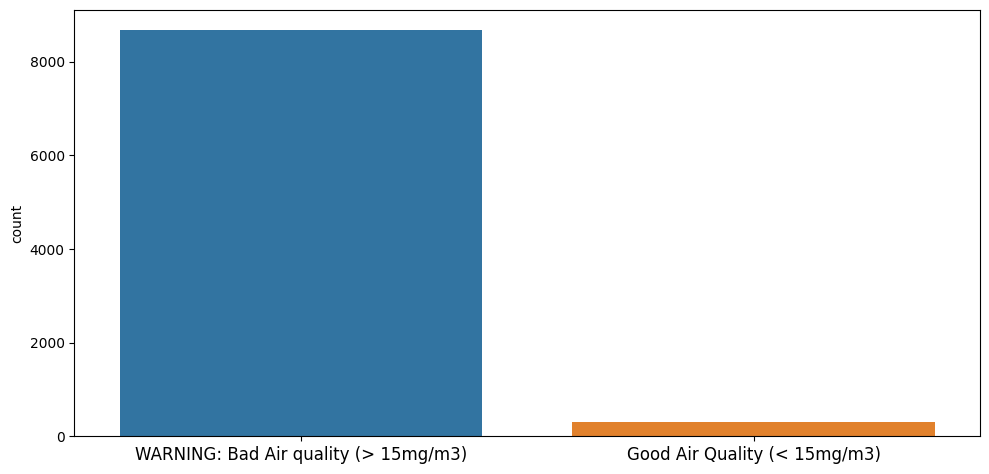

In [86]:
warning = actual_pred_test["PM2_5_predicted_XGB"].apply(lambda x: "WARNING: Bad Air quality (> 15mg/m3)" if x >= 15 else "Good Air Quality (< 15mg/m3)").value_counts().astype("object")
plt.figure(figsize = (10,5))
sns.barplot(data = warning.reset_index(), y = "count", x = "PM2_5_predicted_XGB")
plt.tight_layout()
plt.xlabel("")
plt.xticks(size = 12)

**XGBoost with evaluation set**

In [52]:
X_train_T, X_val, y_train_T, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=53)

In [24]:
X_train_T.shape, X_val.shape, y_train_T.shape, y_val.shape

((16778, 9), (4195, 9), (16778,), (4195,))

In [53]:
xgb_hyperpar_eval = RandomizedSearchCV(estimator= XGBRegressor(), param_distributions=params_xgb,
                                       scoring = scoring, n_iter = 30,
                                    n_jobs=-1, refit="R2")

In [54]:
label_encoder = LabelEncoder()
X_train_T["Place_ID"] = label_encoder.fit_transform(X_train_T["Place_ID"])
X_val["Place_ID"] = label_encoder.fit_transform(X_val["Place_ID"])

In [55]:
xgb_hyperpar_eval.fit(X_train_T, y_train_T, eval_set = [(X_val, y_val)], early_stopping_rounds=10, verbose = 10)

[0]	validation_0-rmse:32.54773
[10]	validation_0-rmse:19.81943
[20]	validation_0-rmse:19.53042
[30]	validation_0-rmse:19.48543
[40]	validation_0-rmse:19.46842


c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Flatko\MyGitRepos\ds-airpollution-project\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "XGB__colsample_bytree", "XGB__gamma", "XGB__learning_rate", "XGB__max_depth", "XGB__n_estimators", "XGB__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:19.49790
[56]	validation_0-rmse:19.50583


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'XGB__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'XGB__n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301]),
                                        'XGB__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])},
                   refit='R2',
                   scoring={'MAPE': 'neg_mean_absolute_percentage_error',
                            'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [56]:
xgb_best_with_evalset = xgb_hyperpar_eval.best_estimator_
xgb_hyperpar_eval.best_params_

{'XGB__subsample': 0.9999999999999999,
 'XGB__n_estimators': 1,
 'XGB__max_depth': 6,
 'XGB__learning_rate': 0.888888888888889,
 'XGB__gamma': 78.94736842105263,
 'XGB__colsample_bytree': 0.9999999999999999}

In [57]:
label_encoder = LabelEncoder()
X_train_new = X_train.copy()
X_train_new["Place_ID"] = label_encoder.fit_transform(X_train_new["Place_ID"])

X_test_new = X_test.copy()
X_test_new["Place_ID"] = label_encoder.fit_transform(X_test_new["Place_ID"])

In [58]:
y_train_pred_xgb_best_with_evalset = xgb_best_with_evalset.predict(X_train_new)
y_test_pred_xgb_best_with_evalset = xgb_best_with_evalset.predict(X_test_new)

print("TRAIN")
print("TUNED: Mean Absolute Percentage Error on TRAIN set for XGBoost:", round(mean_absolute_percentage_error(y_train, y_train_pred_xgb_best_with_evalset), 2),"\n")
print("TUNED: R2 on TRAIN set for XGBoost:", r2_score(y_train, y_train_pred_xgb_best_with_evalset),"\n")
print("TUNED: Adj. R2 on TRAIN set for XGBoost:",  adjusted_r_squared(r2_score(y_train, y_train_pred_xgb_best_with_evalset),X_train),"\n")

print("")
print("TEST")
print("TUNED: Mean Absolute Percentage Error on TEST set for XGBoost:", round(mean_absolute_percentage_error(y_test, y_test_pred_xgb_best_with_evalset), 2),"\n")
print("TUNED: R2 on TEST set for XGBoost:", r2_score(y_test, y_test_pred_xgb_best_with_evalset),"\n")
print("TUNED: Adj. R2 on TEST set for XGBoost:",  adjusted_r_squared(r2_score(y_test, y_test_pred_xgb_best_with_evalset),X_test),"\n")

TRAIN
TUNED: Mean Absolute Percentage Error on TRAIN set for XGBoost: 0.28 

TUNED: R2 on TRAIN set for XGBoost: 0.862877523928447 

TUNED: Adj. R2 on TRAIN set for XGBoost: 0.8628186534287741 


TEST
TUNED: Mean Absolute Percentage Error on TEST set for XGBoost: 0.32 

TUNED: R2 on TEST set for XGBoost: 0.7965917190179113 

TUNED: Adj. R2 on TEST set for XGBoost: 0.7963876986759031 

